<a href="https://colab.research.google.com/github/srilamaiti/spring_2023_w266_final_project_heesuk_iris_srila/blob/main/srila/roberta_ell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Installing new libraries**

In [1]:
!pip install nltk
!pip install wordcloud
!pip install transformers
!pip install emoji==0.6.0
!pip3 install tokenizers
!pip install sentencepiece
!pip install scikit-multilearn
!pip install iterative-stratification

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Importing libraries**

In [4]:
import transformers
print(f'transformers version: {transformers.__version__}')
from transformers import logging as hf_logging
from transformers import BertTokenizer, TFBertModel
from transformers import TFAutoModel, AutoTokenizer
hf_logging.set_verbosity_error()
import nltk
from nltk.tokenize import sent_tokenize
import spacy      
from spacy import displacy
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from wordcloud import ImageColorGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from transformers import RobertaTokenizer, TFRobertaModel
nltk.download('punkt')
ROBERTA_MODEL = "roberta-base"

# Other required libraries
import math
import os
import pandas as pd
import numpy as np
import re
import copy
import sys
import gc
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# distances
from scipy.spatial.distance import pdist, squareform

# data visualization
from matplotlib import cm
import matplotlib.pyplot as plt
from IPython.display import Image

# others
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import set_link_color_palette
from scipy.cluster.hierarchy import linkage

import warnings
warnings.filterwarnings("ignore")

# Data visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.layer_utils import count_params
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import mae
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.losses import binary_crossentropy
from keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from keras.models import load_model

import torch
import torch
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup

transformers version: 4.27.4


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# **General functions**

## **Rounding Off to Custom Decimal Places**

In [5]:
def roundPartial(value, resolution):
    return round (value / resolution) * resolution

## **Set parameters**

In [6]:
def set_config_param(seed = 99):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.backend.clear_session()
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_columns', None)
    
    
set_config_param(20230214)

## **Plot loss and accuracy**

In [7]:
def plot_loss_accuracy(history, col_list):
    fig, ax = plt.subplots(2, 6, figsize=(16, 6), sharex='col', sharey='row')
    fig.tight_layout(pad=5.0)
    for idx, col in enumerate(col_list):

        ax[0, idx].plot(history[col + '_loss'], lw=2, color='darkgoldenrod')
        ax[0, idx].plot(history['val_' + col + '_loss'], lw=2, color='indianred')
        #ax[0, idx].legend(loc='center left')
        ax[0, idx].legend(['Train', 'Validation'], fontsize=5)
        ax[0, idx].set_xlabel('Epochs', size=10)
        ax[0, idx].set_title('Loss: ' + col)

        ax[1, idx].plot(history[col + '_accuracy'], lw=2, color='darkgoldenrod')
        ax[1, idx].plot(history['val_' + col + '_accuracy'], lw=2, color='indianred')
        #ax[0, idx].legend(loc='center left')
        ax[1, idx].legend(['Train', 'Validation'], fontsize=5)
        ax[1, idx].set_xlabel('Epochs', size=10)
        ax[1, idx].set_title('Accuracy: ' + col)

## **Plot Loss and other KPI specified**

In [8]:
def custom_plot(df, kpi_name, kpi_string):
    x_arr = np.arange(len(df['loss'])) + 1
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, df['loss'], '-o', label = 'Train loss')
    ax.plot(x_arr, df['val_loss'], '--<', label = 'Validation loss')
    ax.legend(fontsize = 15)
    ax.set_xlabel('Epoch', size = 15)
    ax.set_ylabel('Loss', size = 15)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, df[kpi_name], '-o', label = 'Train ' + kpi_string)
    ax.plot(x_arr, df['val_' + kpi_name], '--<', label = 'Validation ' + kpi_string)
    ax.legend(fontsize = 15)
    ax.set_xlabel('Epoch', size = 15)
    ax.set_ylabel('Accuracy', size = 15)
    #ax.set_ylim(0,1)
    plt.show()

## **Text Encode**

In [9]:
def text_encode(texts, tokenizer, max_len):
    input_ids = []
    # token_type_ids = []
    attention_mask = []
    
    for text in texts:
        token = tokenizer(text, 
                          max_length = max_len, 
                          truncation = True, 
                          padding = 'max_length',
                          add_special_tokens = True)
        input_ids.append(token['input_ids'])
        # token_type_ids.append(token['token_type_ids'])
        attention_mask.append(token['attention_mask'])
    
    return np.array(input_ids), np.array(attention_mask)

## **Custom metric**

In [10]:
def MCRMSE(y_true, y_pred):
    colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis = 1)
    return tf.reduce_mean(tf.sqrt(colwise_mse), axis = -1, keepdims = True)

## **Build Base Model**

In [11]:
def build_regression_model(loss = 'MCRMSE',
                           model_name = 'Roberta', 
                           dense_dim = 6, 
                           MAX_LEN = 512,
                           learning_rate = 1e-5,
                           dropout = .1,
                           number_of_hidden_layers = 1,
                           hidden_layer_node_count = 64,
                           retrain_layer_count = 0):
    
    # Define inputs
    input_ids = tf.keras.Input(shape = (MAX_LEN ,), dtype = 'int64', name = 'input_ids')
    attention_masks = tf.keras.Input(shape = (MAX_LEN ,), dtype = 'int64', name = 'attention_masks')
    
    if model_name == 'Roberta':
        model_tokenizer = RobertaTokenizer.from_pretrained(ROBERTA_MODEL)
        model = TFRobertaModel.from_pretrained(ROBERTA_MODEL)

    # Adjust the trainable layer weights based on retrain_layer_count
    # If retrain_layer_count is 0, then base model is frozen.
    # If retrain_layer_count is 12, then the entire base model is trainable.
    # And that implies that all the pretrained weights are lost and it relearns
    # from the input data.
    # If retrain_layer_count is between 1 and 11, then the last n layers of
    # the pretrained model retrained.
    if retrain_layer_count == 0:
        # The pretained model is frozen
        model.trainable = False           

    elif retrain_layer_count == 12:  
        # The pretrained model is retrained thru all layers.       
        model.trainable = True     

    else:    
        # Restrict training to the num_train_layers outer transformer layers
        retrain_layer_list = []
        model.trainable = False
    
        for retrain_layer_number in range(retrain_layer_count):

            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layer_list.append(layer_code)
        
        print('Retrain layers: \n', retrain_layer_list)

        for weight_details in model.weights:
            if 'layer_' in weight_details.name and weight_details.name.split(".")[1].split("/")[0] in retrain_layer_list:
                weight_details._trainable = True
                
    # Insert pretrained model layer
    pretrained_transformer = model([input_ids, attention_masks])

    # Get the CLS output off the pretrained model
    cls_token = pretrained_transformer[0][:, 0, :]

    # Append the hidden layer and dropout layer
    layer_list = []
    for layer in range(number_of_hidden_layers):
        if layer == 0:
            hidden_layer = tf.keras.layers.Dense(units      = hidden_layer_node_count
                                               , activation = 'relu'
                                               , name       = 'hidden_layer_' + str(layer + 1)
                                                )(cls_token)
        else:
            hidden_layer = tf.keras.layers.Dense(units      = hidden_layer_node_count
                                               , activation = 'relu'
                                               , name       = 'hidden_layer_' + str(layer + 1)
                                            )(layer_list[-1])
        layer_list.append(hidden_layer)
        dropout_layer = tf.keras.layers.Dropout(dropout, 
                                                name = 'dropout_layer_' + str(layer + 1)
                                               )(hidden_layer) 
        layer_list.append(dropout_layer)

    # Add the output layer
    output = tf.keras.layers.Dense(6,)(layer_list[-1])

    # Build the final model
    regression_model = tf.keras.Model(inputs = [input_ids, attention_masks], outputs = output)
    
    # Model compile
    if loss == 'MCRMSE':
        regression_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
                                 loss      = MCRMSE,
                                 metrics   = MCRMSE
                                )
    
    print(regression_model.summary())
    keras.utils.plot_model(regression_model, 
                           show_shapes = False, 
                           show_dtype = False, 
                           show_layer_names = True, 
                           dpi = 90)
    return regression_model

In [12]:
def model_fit(model, 
              df_train, 
              train_indices,
              val_indices,
              model_name = 'Roberta', 
              MAX_LEN = 512,
              epochs = 5,
              batch_size = 4,
              validation_split = .2):
  
    # Building the tokenizer for the given model
    if model_name == 'Roberta':
        tokenizer = RobertaTokenizer.from_pretrained(ROBERTA_MODEL)

    train_encoded_input_ids, train_encoded_attention_masks = text_encode(df_train.iloc[list(train_indices)]['full_text'], tokenizer, MAX_LEN)
    val_encoded_input_ids, val_encoded_attention_masks = text_encode(df_train.iloc[list(val_indices)]['full_text'], tokenizer, MAX_LEN)

    y_train = np.array(df_train.iloc[list(train_indices)][label_cols], dtype = "float32")
    y_val = np.array(df_train.iloc[list(val_indices)][label_cols], dtype = "float32")
    
    hist = model.fit([train_encoded_input_ids, train_encoded_attention_masks],
                     y_train,
                     validation_data = ([val_encoded_input_ids, val_encoded_attention_masks], 
                                        y_val
                                       ),
                     batch_size = batch_size,        
                     epochs = epochs
                    )

    df_history = pd.DataFrame(hist.history)
    return df_history

In [13]:
def build_base_model(model_layer, learning_rate, dense_dim = 6):
    
    #define inputs
    input_ids = tf.keras.Input(shape = (MAX_LEN ,), dtype = 'int64', name = 'input_ids')
    attention_masks = tf.keras.Input(shape = (MAX_LEN ,), dtype = 'int64', name = 'attention_masks')
    
    #insert BERT layer
    transformer_layer = model_layer([input_ids, attention_masks])
    
    #choose only last hidden-state
    x = transformer_layer[1]
    output = tf.keras.layers.Dense(dense_dim)(x)
    #output = tf.keras.layers.Rescaling(scale=4.0, offset=1.0)(x)
    model = tf.keras.models.Model(inputs = [input_ids, attention_masks], outputs = output)

    model.compile(tf.keras.optimizers.Adam(learning_rate), loss = mse_loss, metrics = mse_metrics)
    
    return model

## **Build a model with custom loss**

In [14]:
def build_base_model_with_custom_loss(model_layer, learning_rate, dense_dim = 6):
    
    #define inputs
    input_ids = tf.keras.Input(shape = (MAX_LEN ,), dtype = 'int64', name = 'input_ids')
    attention_masks = tf.keras.Input(shape = (MAX_LEN ,), dtype = 'int64', name = 'attention_masks')
    
    #insert BERT layer
    transformer_layer = model_layer([input_ids, attention_masks])
    
    #choose only last hidden-state
    x = transformer_layer[1]
    output = tf.keras.layers.Dense(dense_dim)(x)
    #output = tf.keras.layers.Rescaling(scale=4.0, offset=1.0)(x)
    model = tf.keras.models.Model(inputs = [input_ids, attention_masks], outputs = output)

    model.compile(tf.keras.optimizers.Adam(learning_rate), loss = MCRMSE, metrics = MCRMSE)
    
    return model

##**Evaluate**

In [15]:
def evaluate_model(model, y_test, test_encoded_input_ids, test_encoded_attention_masks):
    score = model.evaluate([test_encoded_input_ids, test_encoded_attention_masks], 
                           y_test
                          ) 
    print('\nTest Loss : {:.2f}%'.format(score[0]))
    print('\nTest Accuracy :  {:.2f}%'.format(score[1]))
    return score[0], score[1]

## **Predict**

In [16]:
def predict_model(model, df_test, test_encoded_input_ids, test_encoded_attention_masks, label_cols):
    predictions = model.predict([test_encoded_input_ids, test_encoded_attention_masks])
    df_predictions = pd.DataFrame(predictions, columns=['pred_' + c for c in label_cols])
    for col in label_cols:
        df_predictions['transformed_pred_' + col] = df_predictions['pred_' + col].apply(lambda x : roundPartial(x, .5))
    df_comparison = pd.merge(df_test, df_predictions, left_index = True, right_index = True)
    return df_predictions, df_comparison

## **Plot Model Structure**

In [17]:
def plot_model_structure(model):
    keras.utils.plot_model(model, show_shapes = False, show_dtype = False, show_layer_names = True, dpi = 90)

# **Read input files**

In [18]:
input_train_df = pd.read_csv('train.csv')
input_test_df = pd.read_csv('test.csv')
# Cleaning up full_text : Removing tabl and carriage return characters
input_train_df['full_text'] = input_train_df["full_text"].replace(re.compile(r'[\n\r\t]'), ' ', regex = True)
input_test_df['full_text'] = input_test_df["full_text"].replace(re.compile(r'[\n\r\t]'), ' ', regex = True)


label_cols = input_train_df.columns[2:]
pred_col_list = ['transformed_pred_' + col for col in label_cols]

orig_train_df = copy.deepcopy(input_train_df)
orig_train_df.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal If u change the school policy...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


# **Clustering**

In [19]:
pd.set_option('display.max_rows', None)
pd.DataFrame(orig_train_df[label_cols].value_counts())

0
cohesion syntax vocabulary phraseology grammar conventions    
3.0      3.0    3.0        3.0         2.5     3.0          19
3.5      3.5    3.5        3.5         3.5     3.5          17
2.5      2.5    3.0        2.5         2.5     3.0          17
3.0      3.0    3.0        3.0         2.5     2.5          15
2.5      2.5    3.0        3.0         2.5     2.5          15
3.0      3.0    3.0        3.0         3.0     3.5          14
2.5      2.5    3.0        2.5         2.5     2.5          14
3.0      3.0    3.0        3.0         3.0     3.0          14
         2.5    3.0        2.5         2.5     2.5          13
3.5      3.0    3.5        3.5         3.5     3.5          12
                                               3.0          12
         3.5    3.5        3.0         3.0     3.5          12
2.5      2.5    2.5        2.5         2.5     2.5          11
3.0      2.5    3.0        2.5         2.5     3.0          11
3.5      3.0    3.0        3.0         3.0     3.0          11
3.0      3.5    3.5        3.5         3.0     3.5          11
         2.5    3.0        3.0         2.5     2.5          11
3.5      3.0    3.5        3.5         3.0     3.5          11
3.0      2.5    3.0        2.5         2.0     3.0          10
2.5      2.5    3.0        2.5         2.0     2.5          10
                2.5        2.5         2.0     2.0          10
3.5      3.5    3.5        3.5         3.0     3.5          10
3.0      3.0    3.0        3.0         3.0     2.5          10
                                       2.5     3.5          10
2.0      2.0    2.0        2.0         2.0     2.0          10
2.5      3.0    3.0        3.0         3.0     2.5          10
         2.5    3.0        3.0         2.5     3.0           9
2.0      2.0    2.0        2.0         2.0     2.5           9
2.5      3.0    3.0        3.0         2.5     3.0           9
         2.5    3.0        3.0         2.0     2.5           9
3.5      3.5    3.5        3.0         3.5     3.5           9
3.0      2.5    3.0        3.0         2.5     3.0           9
         3.5    3.5        3.5         3.5     3.0           9
3.5      3.5    3.5        3.5         3.5     3.0           9
3.0      3.0    3.0        3.5         3.5     3.0           9
4.0      3.5    4.0        4.0         3.5     3.5           9
3.0      3.5    3.0        3.5         3.5     3.5           9
2.5      2.5    2.5        2.0         2.0     2.0           9
                           2.5         2.0     2.5           8
3.0      3.0    3.0        2.5         2.0     2.5           8
         3.5    3.0        3.0         3.5     3.5           8
2.5      3.0    3.0        2.5         3.0     2.5           8
3.0      3.0    2.5        2.5         2.5     3.0           8
3.5      3.5    3.5        3.5         3.5     4.0           8
         3.0    3.0        3.0         3.5     3.5           8
3.0      3.0    3.0        2.5         2.5     3.0           8
3.5      3.0    3.5        3.0         3.0     3.0           8
2.5      3.0    3.0        2.5         3.0     3.0           8
3.5      3.5    3.5        3.5         4.0     3.0           8
         3.0    3.5        4.0         3.5     3.0           8
2.5      2.0    3.0        2.0         2.5     2.5           8
3.0      3.5    3.0        3.0         3.0     3.5           8
3.5      3.5    4.0        4.0         3.5     3.5           8
2.5      2.0    2.5        2.0         2.0     2.5           8
3.0      2.5    3.0        2.5         2.0     2.5           8
         3.0    3.0        3.5         3.0     3.0           8
3.5      3.5    3.0        3.0         3.5     3.0           8
3.0      3.0    3.0        3.0         3.5     3.0           8
2.5      2.0    3.0        2.5         2.0     2.5           7
3.5      3.5    3.0        3.5         3.5     3.0           7
3.0      3.5    3.5        3.5         3.0     3.0           7
         3.0    3.5        3.5         3.0     3.5           7
3.5      4.0    4.0        4.

[1 2 1 ... 1 0 1]
within-cluster SSE: 9444.03


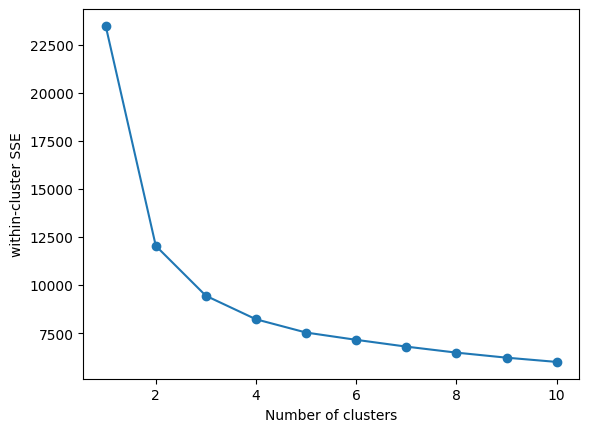

In [20]:
df_rating = copy.deepcopy(orig_train_df[label_cols])
rating_values_array = np.array(df_rating)
# standardize
sc = StandardScaler()
rating_values_array_std = sc.fit(rating_values_array).transform(rating_values_array)

# create an instance of KMeans class using the scikit-learn package
km = KMeans(n_clusters=3,
           init='random',
           #init='k-means++',
           n_init=10,
           max_iter=300,
           tol=1e-04,
           random_state=1234)

# predict k-means classes
y_km = km.fit_predict(rating_values_array_std)

# print cluster predictions
print(y_km)
print('within-cluster SSE: %.2f' % km.inertia_)
# initialize within-cluster SSE list
wc_SSE = []

# fit KMeans models with different numbers of clusters
for i in range(1, 11):
    km = KMeans(n_clusters=i,           
                init='k-means++',
                n_init=10,
                max_iter=300,
                tol=1e-04,
                random_state=0)
    km.fit(rating_values_array_std)
    wc_SSE.append(km.inertia_)
# plot within-cluster SSE for each k
plt.plot(range(1,11), wc_SSE, marker='o');
plt.xlabel('Number of clusters');
plt.ylabel('within-cluster SSE');

We can see that an increase in *k* is associated with a decrease in the within-cluster SSE. 

This is because the examples are closer to the centroid they assigned to.

**The elbow solution**: the optimal *k* is where the within-cluster SSE begings to increase most rapidly.

For this particular example the elbow is at k=5 so we started with a good number of clusters.

## **Silhoutte plots**

A graphical tool to plot a measure of how tightly grouped the examples in the clusters are.

To calculcate the silhoutte coefficient of a single example, apply 3 steps:
- calculate **cluster cohesion**, $a_i$ = average distance between an example, $x_i$, and all other points in the same cluster.
- calculate **cluster separation**, $b_i$, from the next closest cluster = average distance between an example, $x_i$ and all examples in the nearest cluster.
- calculate **the silhouette**, $s_i = \frac{b_i - a_i}{max(b_i,  a_i)}$.


Clustering models with a high silhouette coefficient are said to be dense, where samples in the same cluster are similar to each other, and well separated, where samples in different clusters are not very similar to each other.

Silhouette Coefficient or silhouette score is a metric used to calculate the goodness of a clustering technique. Its value ranges from -1 to 1.

1: Means clusters are well apart from each other and clearly distinguished.

0: Means clusters are indifferent, or we can say that the distance between clusters is not significant.

-1: Means clusters are assigned in the wrong way.

Head of silhouette vals:
 [0.26893129 0.55442358 0.1863127  0.44346258 0.4697772  0.52384654
 0.51964784 0.57055011 0.10506506 0.2903002  0.33724302 0.30407313
 0.07024506 0.44569211 0.45911985 0.51903958 0.52776386 0.31574823
 0.443339   0.27700972 0.55442358 0.55229158 0.34750577 0.5201672
 0.42586496 0.50740919 0.55125136 0.5182399  0.05389755 0.53823953]

Minimum value: 0.03049004378010927 
Maximum value: 0.5864603524734057 

Silhouette_score:  0.3852484371266899


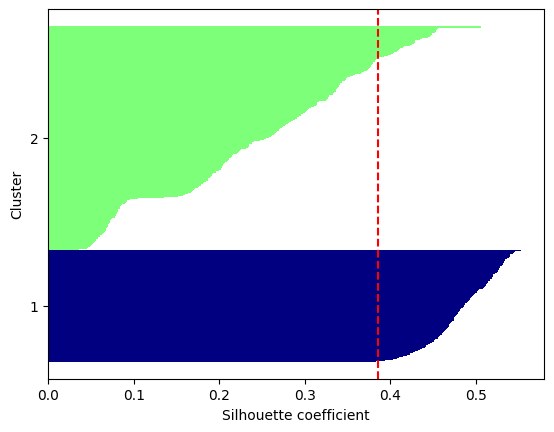

In [21]:
# grab cluster labels and length
km_2 = KMeans(n_clusters=2,
           #init='random',
           init='k-means++',
           n_init=10,
           max_iter=300,
           tol=1e-04,
           random_state=1234)

# predict k-means classes
y_km_2 = km_2.fit_predict(rating_values_array_std)

# find silhouette values
silhouette_vals = silhouette_samples(rating_values_array_std, y_km_2, metric = 'euclidean')
print('Head of silhouette vals:\n', silhouette_vals[:30])
print('\nMinimum value:', min(silhouette_vals),
      '\nMaximum value:', max(silhouette_vals), '\n')
#print(silhouette_score(rating_values_array_std, y_km_2, metric = 'euclidean'))
cluster_labels = np.unique(y_km_2)
n_clusters = len(cluster_labels)

y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    # grab silhouette values for each cluster
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    # plot y and x axes
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
# plot average value across clusters    
silhouette_vals = silhouette_samples(rating_values_array_std, y_km_2, metric='euclidean')
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster');
plt.xlabel('Silhouette coefficient');

# find silhouette values
silhouette_score = silhouette_score(rating_values_array_std, y_km_2, metric='euclidean')
print(f'Silhouette_score: ', silhouette_score)

In [23]:
orig_train_df['rating_cluster'] = y_km_2
orig_train_df.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,rating_cluster
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,1
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,0
2,00299B378633,"Dear, Principal If u change the school policy...",3.0,3.5,3.0,3.0,3.0,2.5,0
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,1
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,0


In [24]:
orig_train_df[orig_train_df.rating_cluster == 0].head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,rating_cluster
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,0
2,00299B378633,"Dear, Principal If u change the school policy...",3.0,3.5,3.0,3.0,3.0,2.5,0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,0
7,008DDDDD8E8D,I think it's a good idea for the estudnets to ...,2.5,2.5,2.5,2.5,2.5,2.0,0
9,009F4E9310CB,Asking more than one person for and advice hel...,3.0,3.0,3.5,2.5,3.0,2.5,0


In [25]:
orig_train_df[orig_train_df.rating_cluster == 1].head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,rating_cluster
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,1
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,1
5,004AC288D833,"Dear Principal, Our school should have a co...",3.5,4.0,4.0,3.5,3.5,4.0,1
6,005661280443,Imagine if you could prove other people that y...,3.5,4.0,3.5,3.5,4.0,4.0,1
8,009BCCC61C2A,positive attitude is the key to success. I agr...,3.0,3.0,3.5,3.5,3.0,3.0,1


In [40]:
df_cluster0 = orig_train_df[orig_train_df.rating_cluster == 0]
df_cluster1 = orig_train_df[orig_train_df.rating_cluster == 1]

In [41]:
print(f"Length of cluster 0 : {len(df_cluster0)} and length of cluster 1 : {len(df_cluster1)}")

Length of cluster 0 : 1996 and length of cluster 1 : 1915


## **Validating the cluster assignment**

In [42]:
np.max(df_cluster0), np.min(df_cluster0)

(text_id                                                FFDC4011AC9C
 full_text         yes, I am agree with that ..  Because it's tru...
 cohesion                                                        4.0
 syntax                                                          4.0
 vocabulary                                                      4.0
 phraseology                                                     4.0
 grammar                                                         4.0
 conventions                                                     4.0
 rating_cluster                                                    0
 dtype: object,
 text_id                                                0022683E9EA5
 full_text         !!Ops Ops!!  Technology allow people to comple...
 cohesion                                                        1.0
 syntax                                                          1.0
 vocabulary                                                      1.0
 phraseology      

In [87]:
np.max(df_cluster1), np.min(df_cluster1)

(text_id                                                FFED00D6E0BD
 full_text         ~Aesop said: "  No act of kindness, no matter ...
 cohesion                                                        5.0
 syntax                                                          5.0
 vocabulary                                                      5.0
 phraseology                                                     5.0
 grammar                                                         5.0
 conventions                                                     5.0
 rating_cluster                                                    1
 dtype: object,
 text_id                                                0016926B079C
 full_text         " Determine never to be idle... It is wonderfu...
 cohesion                                                        2.5
 syntax                                                          2.5
 vocabulary                                                      2.5
 phraseology      

**Cluster ID 1 denotes the records where at least one KPI has score 4 or more.**

In [92]:
# Cluster 1 has at least one KPI value which is 4 or more.
# So not having any KPI more than 4 is an anomaly.
df_cluster1_anomaly = df_cluster1[ ~    ((np.round(df_cluster1.cohesion,1) >= 4.0) |
                                        (np.round(df_cluster1.syntax,1) >= 4.0) |
                                        (np.round(df_cluster1.vocabulary,1) >= 4.0) | 
                                        (np.round(df_cluster1.phraseology,1) >= 4.0) | 
                                        (np.round(df_cluster1.grammar,1) >= 4.0) |
                                        (np.round(df_cluster1.conventions,1) >= 4.0)
                                       )
                                  ]
df_cluster1_anomaly.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,rating_cluster
8,009BCCC61C2A,positive attitude is the key to success. I agr...,3.0,3.0,3.5,3.5,3.0,3.0,1
10,00B21F9B726F,Do you think its a good idea for students to c...,3.0,3.5,3.5,3.5,3.5,3.0,1
32,032EA4B76BF5,Some people may think that positive attitude i...,3.5,3.5,3.0,3.0,3.5,3.0,1
53,046C6FB91CBA,Distance learning can be very helpful to stude...,3.0,3.5,3.0,3.0,3.5,3.5,1
55,04788D56AC58,Generic_City is the one place in this world i ...,3.5,3.0,3.0,3.0,3.5,3.0,1


**Clsuter ID 0 denotes the records where all the KPI values have 3 or below scores.**

In [94]:
# Cluster 0 has all the kPI values are less than or equal to 3.
# So not having any KPI more than 3 is an anomaly.
df_cluster0_anomaly = df_cluster0[~((np.round(df_cluster0.cohesion,1) <= 3.0) &
                                    (np.round(df_cluster0.syntax,1) <= 3.0) &
                                    (np.round(df_cluster0.vocabulary,1) <= 3.0) &
                                    (np.round(df_cluster0.phraseology,1) <= 3.0) & 
                                    (np.round(df_cluster0.grammar,1) <= 3.0) &
                                    (np.round(df_cluster0.conventions,1) <= 3.0)
                                   )
                                ]
df_cluster0_anomaly.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,rating_cluster
2,00299B378633,"Dear, Principal If u change the school policy...",3.0,3.5,3.0,3.0,3.0,2.5,0
9,009F4E9310CB,Asking more than one person for and advice hel...,3.0,3.0,3.5,2.5,3.0,2.5,0
12,00D281524375,Technology allows people to do many things suc...,3.5,2.5,3.5,3.0,3.0,3.0,0
18,017802562E71,"March 12, 20019 The technology allows people ...",3.0,2.0,3.5,2.5,2.5,2.5,0
34,0369AD4B5726,I would agree with being honest at all times b...,2.0,3.0,3.5,3.0,3.0,3.5,0


In [96]:
print(f"Anomaly record count in cluster 0 : {len(df_cluster0_anomaly)} and Anomaly record count in cluster 1 : {len(df_cluster1_anomaly)}")

Anomaly record count in cluster 0 : 694 and Anomaly record count in cluster 1 : 474


**We need to readjust the asignment of the clusters.**

**In the process, we have to exclude the same cluster anomany records and include other cluster's anomaly record.**

In [97]:
len(df_cluster0) , len(df_cluster0_anomaly), len(df_cluster0) - len(df_cluster0_anomaly)

(1996, 694, 1302)

In [98]:
len(df_cluster1) , len(df_cluster1_anomaly), len(df_cluster1) - len(df_cluster1_anomaly)

(1915, 474, 1441)

In [99]:
len(df_cluster0) - len(df_cluster0_anomaly) + len(df_cluster1_anomaly)

1776

In [100]:
len(df_cluster1) - len(df_cluster1_anomaly) + len(df_cluster0_anomaly)

2135

In [101]:
df_cluster1_anomaly['rating_cluster'] = 0
df_cluster0_anomaly['rating_cluster'] = 1

In [102]:
combined = df_cluster0.append(df_cluster0_anomaly)
df_cluster0_excpt_cluster0_anomaly = combined[~combined.index.duplicated(keep = False)]

combined = df_cluster1.append(df_cluster1_anomaly)
df_cluster1_excpt_cluster1_anomaly = combined[~combined.index.duplicated(keep = False)]

In [103]:
len(df_cluster0_excpt_cluster0_anomaly), len(df_cluster1_excpt_cluster1_anomaly)

(1302, 1441)

In [104]:
new_df_cluster0 = pd.concat([df_cluster0_excpt_cluster0_anomaly, df_cluster1_anomaly])
new_df_cluster1 = pd.concat([df_cluster1_excpt_cluster1_anomaly, df_cluster0_anomaly])

In [105]:
print(f"Length of newly readjusted cluster 0 : {len(new_df_cluster0)} and length of newly readjusted cluster 1 : {len(new_df_cluster1)}")

Length of newly readjusted cluster 0 : 1776 and length of newly readjusted cluster 1 : 2135


# **Model parameter setup**

In [106]:
set_config_param()

# Fixed parameters
dense_dim = 6
number_of_splits = 5
random_state = 2023
MAX_LEN = 512
mse_loss = tf.keras.losses.mse
mse_metrics = tf.keras.metrics.mse

# Variable parameters
epochs = 5
batch_size = 4
learning_rate = 1e-5
validation_split = .2
dropout = .1
number_of_hidden_layers = 1
hidden_layer_node_count = 64
retrain_layer_count = 0

# Variable parameter dictionary
param_list = [
                 # Completely frozen base layer
                 {'epochs'                  : 5,
                  'batch_size'              : 4,
                  'learning_rate'           : 1e-5,
                  'validation_split'        : .2,
                  'dropout'                 : .1,
                  'number_of_hidden_layers' : 1,
                  'hidden_layer_node_count' : 64,
                  'retrain_layer_count'     : 0
                 },
                 # Completely unfrozen base layer
                 {'epochs'                  : 5,
                  'batch_size'              : 4,
                  'learning_rate'           : 1e-5,
                  'validation_split'        : .2,
                  'dropout'                 : .1,
                  'number_of_hidden_layers' : 1,
                  'hidden_layer_node_count' : 64,
                  'retrain_layer_count'     : 12
                 },
                 # Partially frozen base layer
                 {'epochs'                  : 5,
                  'batch_size'              : 4,
                  'learning_rate'           : 1e-5,
                  'validation_split'        : .2,
                  'dropout'                 : .1,
                  'number_of_hidden_layers' : 1,
                  'hidden_layer_node_count' : 64,
                  'retrain_layer_count'     : 6
                 }
             ]

# **Model building**

Original test data is very limited, there are only 3 records and it does not have labels to test. So we decided to repurpose the given train data to split into train, test and validation sets.

We take the initial input train set and split into train and test set with 8:2 ratio.

The train part is then going thru k fold cross validation and get tested on validation set and final test is done on the test set. Final test accuracy will be the average MCRMSE score across k-folds.



In [ ]:
# Combining the two clusters' data
orig_train_df = pd.concat([new_df_cluster0, new_df_cluster1])

# shuffling them back again
shuffle = np.random.permutation(np.arange(orig_train_df.shape[0]))
orig_train_df = orig_train_df.iloc[shuffle]

# Splitting the data in 80:20 split
split = (0.8, 0.2)
splits = np.multiply(len(orig_train_df), split).astype(int)
df_train, df_test = orig_train_df[ : splits[0]], orig_train_df[splits[0] : ]

y_test = np.array(df_test[label_cols], dtype = "float32")

MCRMSE_list = []

'''
rating_cluster has two values 0 and 1.
We are doing k fold with stratification using rating_cluster.
We introduced this new column to split on as as our data ouput is multi class
and multi label with continuous values and traditional k fold split does not
support that.
This new column will help us to see if our model is performing better for which 
group : above or below average.
'''
for idx, param_entry in enumerate(param_list):
    
    epoch_val = param_entry['epochs']
    batch_size_val = param_entry['epochs']
    learning_rate_val = param_entry['learning_rate']
    validation_split_val = param_entry['validation_split']
    dropout_val = param_entry['dropout']
    number_of_hidden_layers_val = param_entry['number_of_hidden_layers']
    hidden_layer_node_count_val = param_entry['hidden_layer_node_count']
    retrain_layer_count_val = param_entry['retrain_layer_count']

    for kfold, (train_indices, val_indices) in enumerate(StratifiedKFold(n_splits     = number_of_splits, 
                                                                         shuffle      = True, 
                                                                         random_state = random_state
                                                                         ).split(df_train['rating_cluster'].values.tolist(), 
                                                                                 df_train['rating_cluster'].values.tolist()
                                                                                )
                                                         ):
        print("************************")
        print(f"Iteration : {idx + 1}")
        print("Parameters...")
        print(f"Epochs : {epoch_val}")
        print(f"Batch size : {batch_size_val}")
        print(f"Learning rate : {learning_rate_val}")
        print(f"Validation split : {validation_split_val}")
        print(f"Dropout : {dropout_val}")
        print(f"Number of hidden layers : {number_of_hidden_layers_val}")
        print(f"Hidden layer node count : {hidden_layer_node_count_val}")
        print(f"Retrain layer count : {retrain_layer_count_val}")
        print("************************")
        print(f"k-fold : {kfold + 1}")
        print(f"length of train data : {len(train_indices)}")
        print(f"length of validation data : {len(val_indices)}")
        print("************************")
        
        # Model building
        print("Building model...")
        regression_model = build_regression_model(loss                    = 'MCRMSE',
                                                  model_name              = 'Roberta', 
                                                  dense_dim               = dense_dim, 
                                                  MAX_LEN                 = MAX_LEN,
                                                  learning_rate           = learning_rate_val,
                                                  dropout                 = dropout_val,
                                                  number_of_hidden_layers = number_of_hidden_layers_val,
                                                  hidden_layer_node_count = hidden_layer_node_count_val,
                                                  retrain_layer_count     = retrain_layer_count_val
                                                 )
        
        # Model fitting
        print("Fitting model...")
        df_history = model_fit(regression_model, 
                               df_train, 
                               train_indices,
                               val_indices,
                               model_name = 'Roberta', 
                               MAX_LEN = MAX_LEN,
                               epochs = epoch_val,
                               batch_size = batch_size_val,
                               validation_split = validation_split_val
                              )
        print(df_history.T)

        print("Plotting loss and MCRMSE...")
        custom_plot(df_history, 'MCRMSE', 'MCRMSE')

        # Prep for model evaluation with test data
        print("Evaluating mode...")
        roberta_tokenizer = RobertaTokenizer.from_pretrained(ROBERTA_MODEL)
        test_encoded_input_ids, test_encoded_attention_masks = text_encode(df_test['full_text'], 
                                                                           roberta_tokenizer, 
                                                                           MAX_LEN
                                                                          )
        # Model evaluation
        test_loss, test_accuracy = evaluate_model(regression_model, 
                                                  y_test, 
                                                  test_encoded_input_ids, 
                                                  test_encoded_attention_masks
                                                 )

        # Model prediction
        print("Model prediction...")
        df_prediction, df_comparison = predict_model(regression_model, 
                                                     df_test, 
                                                     test_encoded_input_ids, 
                                                     test_encoded_attention_masks, 
                                                     label_cols)

        print("Plotting model structure...")
        keras.utils.plot_model(regression_model, 
                               show_shapes      = False, 
                               show_dtype       = False, 
                               show_layer_names = True, 
                               dpi              = 90
                              )

        print("Appending to kpi list...")
        MCRMSE_list.append({'model_name'                  : 'roberta-base',
                            'iteration'                   : idx + 1,
                            'epoch_val'                   : epoch_val,
                            'batch_size_val'              : batch_size_val,
                            'learning_rate_val'           : learning_rate_val,
                            'validation_split_val'        : validation_split_val,
                            'dropout_val'                 : dropout_val,
                            'number_of_hidden_layers_val' : number_of_hidden_layers_val,
                            'hidden_layer_node_count_val' : hidden_layer_node_count_val,
                            'retrain_layer_count_val'     : retrain_layer_count_val,
                            'fold'                        : kfold + 1, 
                            'train_loss'                  : df_history.iloc[-1][0],
                            'train_accuracy'              : df_history.iloc[-1][1],
                            'val_loss'                    : df_history.iloc[-1][2],
                            'val_accuracy'                : df_history.iloc[-1][2],
                            'test_loss'                   : test_loss,
                            'test_accuracy'               : test_accuracy
                           }
                          )
        # Saving the model
        print("Saving the model...")
        model_file_name = 'regression_model_iter_' + str(idx + 1) + '_kfold_' + str(kfold + 1) + ".h5"
        regression_model.save(model_file_name)

kpi_col_list = ['model_name',
                'iteration',
                'epoch_val',
                'batch_size_val',
                'learning_rate_val',
                'validation_split_val',
                'dropout_val',
                'number_of_hidden_layers_val',
                'hidden_layer_node_count_val',
                'retrain_layer_count_val',
                'fold', 
                'train_loss', 
                'train_accuracy', 
                'val_loss', 
                'val_accuracy', 
                'test_loss', 
                'test_accuracy'
               ]
df_MCRMSE = pd.DataFrame(MCRMSE_list, columns = kpi_col_list)    
df_MCRMSE.to_csv("kpi_stats.csv", index = False)
df_MCRMSE    

************************
Iteration : 1
Parameters...
Epochs : 5
Batch size : 5
Learning rate : 1e-05
Validation split : 0.2
Dropout : 0.1
Number of hidden layers : 1
Hidden layer node count : 64
Retrain layer count : 0
************************
k-fold : 1
length of train data : 2502
length of validation data : 626
************************
Building model...


In [ ]:
print("Average test accuracy and loss...")
print(df_MCRMSE.groupby(['model_name', 'iteration']).agg({'test_loss'      : np.mean, 
                                                          'test_accuracy'  : np.mean
                                                         }
                                                        ))